## CLASSIGY NEW DATA


In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib widget

import glob
from pathlib import Path

import arviz as az
import cloudpickle
import joblib
import numpy as np
import pandas as pd
from sqlalchemy import create_engine

from ppcluster import logger
from ppcluster.config import ConfigManager
from ppcluster.database import (
    get_dic_analysis_by_ids,
    get_dic_analysis_ids,
    get_dic_data,
    get_image,
)
from ppcluster.mcmc import (
    assign_spatial_priors,
    compute_posterior_assignments,
    plot_1d_velocity_clustering,
    compute_cluster_statistics,
)
from ppcluster.preprocessing import (
    apply_dic_filters,
    preproc_features,
)
from ppcluster.roi import PolygonROISelector
import matplotlib.pyplot as plt

# Load configuration
config = ConfigManager()
db_engine = create_engine(config.db_url)

In [2]:
date = "2024-08-28"
camera_name = "PPCX_Tele"
output_dir = Path("output") / f"{camera_name}_PyMC"

# Load posterior and scaler
PRIOR_STRENGTH = 0.4
reference_start_date = "2024-08-23"
reference_end_date = "2024-08-28"
posterior_base_name = (
    f"PPCX_mcmc_{camera_name}_pooled_{reference_start_date}_{reference_end_date}"
)
idata = az.from_netcdf(output_dir / f"{posterior_base_name}_posterior.idata.nc")
scaler = joblib.load(output_dir / f"{posterior_base_name}_scaler.joblib")

In [3]:
# Get DIC data
dic_ids = get_dic_analysis_ids(db_engine, camera_name=camera_name, reference_date=date)
if len(dic_ids) == 0:
    raise ValueError("No DIC analyses found for the given criteria")
elif len(dic_ids) > 1:
    logger.warning(
        "Multiple DIC analyses found for the given criteria. Using the first one."
    )
dic_id = dic_ids[0]

dic_analyses = get_dic_analysis_by_ids(db_engine=db_engine, dic_ids=[dic_id])
master_image_id = dic_analyses["master_image_id"].iloc[0]
img = get_image(
    master_image_id,
    camera_name=camera_name,
    config=config,
)
df = get_dic_data(dic_id, config=config)
df = apply_dic_filters(
    df,
    filter_outliers=config.get("dic.filter_outliers"),
    tails_percentile=config.get("dic.tails_percentile"),
)

selector = PolygonROISelector.from_file(config.get("data.roi_path"))
df = selector.filter_dataframe(df, x_col="x", y_col="y")
logger.info(f"Data shape after filtering: {df.shape}")

2025-09-12 16:11:09 | [INFO    ] Found 1 DIC analyses matching criteria
2025-09-12 16:11:10 | [INFO    ] Starting DIC filtering pipeline with 5251 points
2025-09-12 16:11:10 | [INFO    ] Percentile filtering: 5251 -> 5145 points (removed 106 outliers)
2025-09-12 16:11:10 | [INFO    ] Min velocity filtering: 5145 -> 5145 points (removed 0 points below 0.0)
2025-09-12 16:11:10 | [INFO    ] DIC filtering pipeline completed: 5251 -> 5145 points (removed 106 total)
2025-09-12 16:11:10 | [INFO    ] Data shape after filtering: (2295, 5)


Filtered 5145 points to 2295 points inside polygon


In [4]:
# Prepare new data
variables_names = config.get("clustering.variables_names")
df_features = preproc_features(df)
X = df_features[variables_names].values
X_scaled = scaler.transform(X)

# # Assign spatial priors
sector_files = sorted(glob.glob(config.get("data.sector_prior_pattern")))
sector_selectors = [PolygonROISelector.from_file(f) for f in sector_files]
prior_probs = assign_spatial_priors(df, sector_selectors, prior_strength=PRIOR_STRENGTH)

2025-09-12 16:11:10 | [INFO    ] Sector 0: 297 points with strong prior
2025-09-12 16:11:10 | [INFO    ] Sector 1: 407 points with strong prior
2025-09-12 16:11:10 | [INFO    ] Sector 2: 440 points with strong prior
2025-09-12 16:11:10 | [INFO    ] Sector 3: 963 points with strong prior


2025-09-12 16:11:11 | [INFO    ] Results saved to output/PPCX_Tele_PyMC/PPCX_mcmc_PPCX_Tele_2024-08-28_dic-634_results.pkl


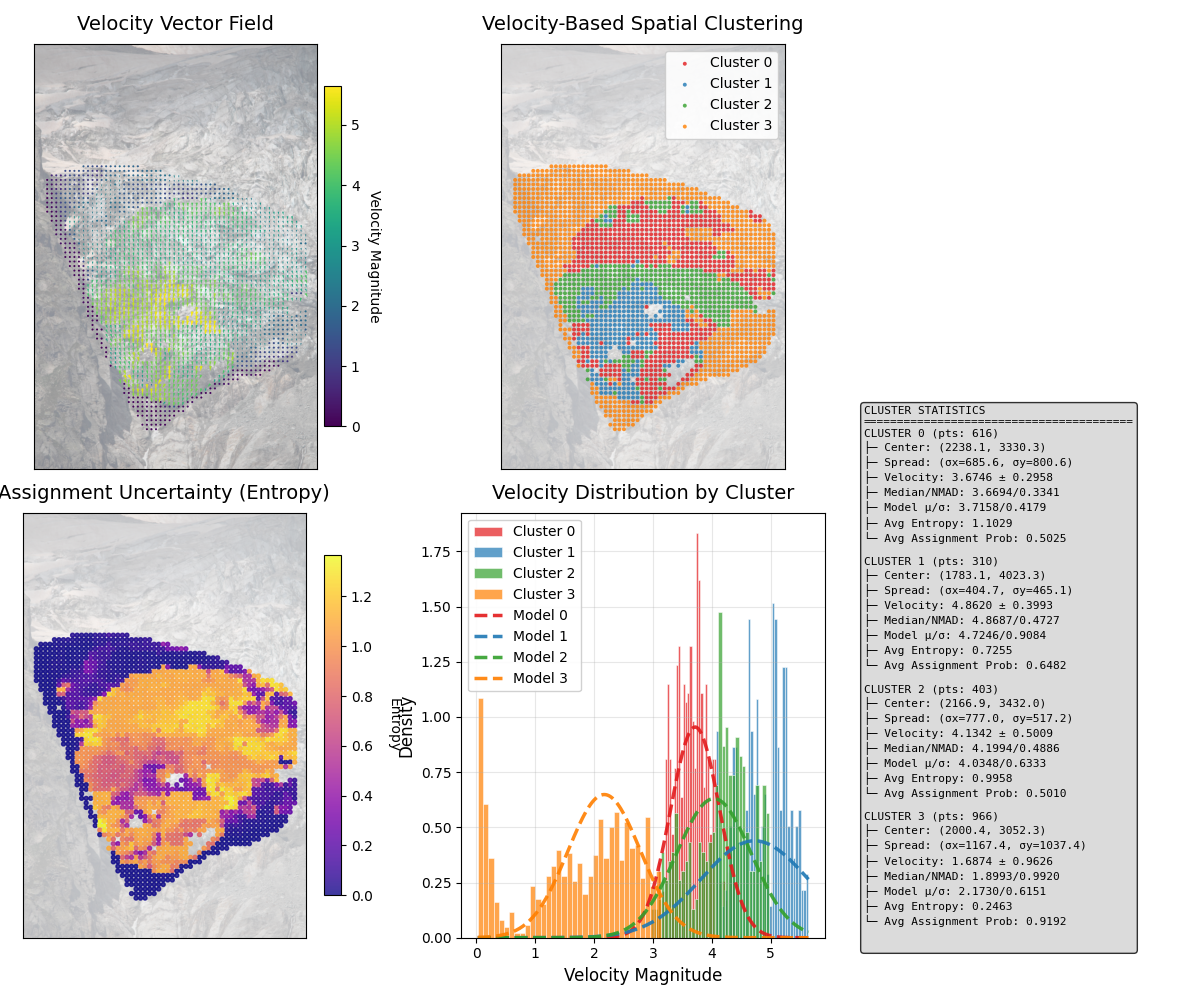

In [5]:
# compute assignments for new single-day data (fast option using posterior mean)
posterior_probs, cluster_pred, entropy = compute_posterior_assignments(
    idata, X_scaled, prior_probs, use_posterior_mean=True
)

# Save results to pickle
outbasepath = output_dir / f"PPCX_mcmc_{camera_name}_{date}_dic-{dic_id}_results"
output_dir.mkdir(parents=True, exist_ok=True)
with open(outbasepath.with_suffix(".pkl"), "wb") as f:
    cloudpickle.dump(
        {
            "data": df,
            "df_features": df_features,
            "var_names": variables_names,
            "features_scaled": X_scaled,
            "posterior_probs": posterior_probs,
            "cluster_pred": cluster_pred,
            "entropy": entropy,
            "scaler": scaler,
            "idata": idata,
        },
        f,
    )
    logger.info(f"Results saved to {outbasepath.with_suffix('.pkl')}")

# Plot results
fig, uncertainty, stats = plot_1d_velocity_clustering(
    df_features,
    img,
    idata=idata,
    cluster_pred=cluster_pred,
    posterior_probs=posterior_probs,
    scaler=scaler,
)
fig.savefig(
    outbasepath.with_suffix(".png"),
    dpi=300,
    bbox_inches="tight",
)

In [6]:
# Post processing
median_entropy_treshold = 0.6
median_entropy = np.median(entropy)

In [7]:
median_entropy

np.float64(0.8591919131914151)

In [8]:
posterior_probs

array([[1.21839126e-14, 4.64910964e-04, 9.74518611e-07, 9.99534115e-01],
       [2.00190022e-14, 4.66193286e-04, 1.12132300e-06, 9.99532685e-01],
       [9.03478522e-15, 2.32989155e-04, 5.44705498e-07, 9.99766466e-01],
       ...,
       [1.65949758e-04, 6.33053935e-03, 4.09622331e-03, 9.89407288e-01],
       [8.38523674e-05, 5.24771380e-03, 2.96719229e-03, 9.91701242e-01],
       [4.33106127e-03, 1.82961674e-02, 2.14719501e-02, 9.55900821e-01]],
      shape=(2295, 4))

In [9]:
cluster_pred

array([3, 3, 3, ..., 3, 3, 3], shape=(2295,))

In [10]:
stats_df = pd.DataFrame(stats).T
stats_df


,count,x_mean,y_mean,x_std,y_std,velocity_mean,velocity_std,velocity_median,velocity_nmad,avg_entropy,avg_assignment_prob,model_mu,model_sigma
0,616.0,2238.129870,3330.285714,685.642468,800.636482,3.674591,0.295813,3.669390,0.334077,1.102938,0.502490,3.715824,0.417899
1,310.0,1783.122581,4023.329032,404.690504,465.051494,4.861965,0.399262,4.868707,0.472687,0.725505,0.648159,4.724583,0.908396
2,403.0,2166.947891,3432.019851,777.005517,517.198638,4.134179,0.500901,4.199446,0.488599,0.995764,0.501023,4.034849,0.633320
3,966.0,2000.364389,3052.322981,1167.407150,1037.394153,1.687425,0.962603,1.899350,0.991986,0.246320,0.919151,2.173012,0.615072


In [11]:
from scipy import ndimage
from scipy.spatial import cKDTree


def create_2d_grid(
    x: np.ndarray,
    y: np.ndarray,
    labels: np.ndarray | None = None,
    grid_spacing: float | None = None,
):
    if grid_spacing is None:
        # Estimate grid spacing from minimum distances
        points = np.column_stack((x, y))
        tree = cKDTree(points)
        # Query the nearest neighbor point (k=2)
        distances, _ = tree.query(points, k=2)
        # distances[:, 1] is distance to nearest neighbor
        grid_spacing = np.median(distances[:, 1])
        if any(np.isnan(distances[:, 1])):
            logger.warning("Some points have no neighbors within the search radius.")
        if any(distances[:, 1] != grid_spacing):
            logger.warning(
                "Points are not on a regular grid. Interpolation may be needed."
            )
        logger.info(f"Estimated grid spacing: {grid_spacing:.2f}")

    # Create regular grid
    x_min, x_max = df["x"].min(), df["x"].max()
    y_min, y_max = df["y"].min(), df["y"].max()
    x_grid = np.arange(x_min, x_max + grid_spacing, grid_spacing)
    y_grid = np.arange(y_min, y_max + grid_spacing, grid_spacing)

    # Create meshgrid
    X, Y = np.meshgrid(x_grid, y_grid)

    # Initialize with NaN for no label
    label_grid = np.full(X.shape, np.nan)

    if labels is not None:
        # Map the labels to the grid
        for i, (xi, yi) in enumerate(zip(x, y)):
            ix = np.argmin(np.abs(x_grid - xi))
            iy = np.argmin(np.abs(y_grid - yi))
            label_grid[iy, ix] = labels[i]

    return X, Y, label_grid


def remove_small_grid_components(label_grid, min_size=5, connectivity=8):
    """
    Remove/merge small connected components in a 2D label grid.
    Small components are reassigned to the most common neighbor label (if any),
    otherwise set to NaN.
    Args:
        label_grid: 2D numpy array with labels (can contain np.nan for empty cells)
        min_size: minimum size (in grid cells) to keep a component
        connectivity: 4 or 8 (neighbors)
    Returns:
        cleaned_grid: 2D array with small components merged/removed
    """
    cleaned = label_grid.copy().astype(float)
    structure = (
        np.ones((3, 3), dtype=bool)
        if connectivity == 8
        else np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype=bool)
    )

    # iterate over each distinct label value (ignore NaN)
    unique_labels = np.unique(label_grid[~np.isnan(label_grid)])
    for lab in unique_labels:
        mask = label_grid == lab
        if not np.any(mask):
            continue
        components, ncomp = ndimage.label(mask, structure=structure)
        for comp_id in range(1, ncomp + 1):
            comp_mask = components == comp_id
            comp_size = comp_mask.sum()
            if comp_size < min_size:
                # dilate component to get neighbor cells
                nb_mask = ndimage.binary_dilation(
                    comp_mask, structure=np.ones((3, 3))
                ) & (~comp_mask)
                neighbor_labels = cleaned[nb_mask]
                # exclude NaNs and the same label
                neighbor_labels = neighbor_labels[~np.isnan(neighbor_labels)]
                neighbor_labels = neighbor_labels[neighbor_labels != lab]
                if neighbor_labels.size > 0:
                    # pick most common neighbor label
                    new_label = np.bincount(neighbor_labels.astype(int)).argmax()
                    cleaned[comp_mask] = new_label
                else:
                    cleaned[comp_mask] = np.nan
    return cleaned


def plot_cluster_labels_on_image(
    df_features,
    img,
    cluster_pred,
    ax=None,
    title="Velocity-Based Spatial Clustering",
    markersize=8,
):
    """Plot cluster labels over optional background image."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title(title, fontsize=14, pad=10)
    if img is not None:
        ax.imshow(img, alpha=0.3, cmap="gray")

    unique_labels = np.unique(cluster_pred)
    palette = [
        "#E31A1C",
        "#1F78B4",
        "#33A02C",
        "#FF7F00",
        "#6A3D9A",
        "#B15928",
        "#A6CEE3",
        "#B2DF8A",
        "#FB9A99",
        "#FDBF6F",
    ]
    color_map = {}
    for i, lab in enumerate(sorted(unique_labels)):
        color_map[lab] = "#7f7f7f" if lab == -1 else palette[i % len(palette)]

    for label in sorted(unique_labels):
        mask = cluster_pred == label
        if np.any(mask):
            ax.scatter(
                df_features.loc[mask, "x"],
                df_features.loc[mask, "y"],
                c=color_map[label],
                s=markersize,
                alpha=0.8,
                label=f"Cluster {label}",
                edgecolors="none",
            )

    ax.legend(loc="upper right", framealpha=0.9, fontsize=10)
    ax.set_aspect("equal")
    ax.set_xticks([])
    ax.set_yticks([])
    return ax


def close_small_holes(
    label_grid, max_hole_size=10, connectivity=8, require_single_neighbor=True
):
    """
    Close small NaN-holes in a 2D label grid.

    Rules:
      - Only close holes whose size (number of NaN cells) <= max_hole_size.
      - Only close if the dilated border of the hole contains no NaNs
        (i.e. data all around the hole).
      - If require_single_neighbor is True the border must contain a single unique
        label; otherwise the most common border label is used.

    Args:
      label_grid: 2D ndarray with labels (NaN for empty cells).
      max_hole_size: maximum hole area (in grid cells) to fill.
      connectivity: 4 or 8 connectivity for labeling/dilation.
      require_single_neighbor: if True, require single neighbor label on border.

    Returns:
      new_grid: copy of label_grid with selected holes filled.
    """
    new_grid = label_grid.copy().astype(float)
    structure = (
        np.ones((3, 3), dtype=bool)
        if connectivity == 8
        else np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], dtype=bool)
    )

    # mask of holes (NaNs)
    hole_mask_all = np.isnan(label_grid)
    if not np.any(hole_mask_all):
        return new_grid

    # label each hole component
    comp_labels, ncomp = ndimage.label(hole_mask_all, structure=structure)
    for comp_id in range(1, ncomp + 1):
        comp_mask = comp_labels == comp_id
        comp_size = int(comp_mask.sum())
        if comp_size > max_hole_size:
            continue

        # dilate to get border cells
        dilated = ndimage.binary_dilation(comp_mask, structure=np.ones((3, 3)))
        border_mask = dilated & (~comp_mask)

        # if any border cell is NaN -> not fully surrounded by data
        border_vals = new_grid[border_mask]
        if border_vals.size == 0 or np.any(np.isnan(border_vals)):
            continue

        # get unique neighbor labels
        unique_neighbors, counts = np.unique(border_vals, return_counts=True)
        if unique_neighbors.size == 0:
            continue

        if require_single_neighbor:
            # require border to be all same label
            if unique_neighbors.size == 1:
                fill_label = unique_neighbors[0]
            else:
                continue
        else:
            # pick most common neighbor label
            fill_label = unique_neighbors[np.argmax(counts)]

        # fill hole with chosen label
        new_grid[comp_mask] = fill_label

    return new_grid

In [ ]:
X, Y, label_grid = create_2d_grid(
    x=df["x"].values, y=df["y"].values, labels=cluster_pred, grid_spacing=None
)

# Usage (after you built X, Y, label_grid)
min_size = 20
cleaned_grid = remove_small_grid_components(
    label_grid, min_size=min_size, connectivity=8
)
min_size = 5
cleaned_grid = remove_small_grid_components(
    cleaned_grid, min_size=min_size, connectivity=8
)
cleaned_grid_filled = close_small_holes(
    cleaned_grid, max_hole_size=30, connectivity=8, require_single_neighbor=True
)

# Map cleaned grid back to original point ordering
# x coordinates per column: X[0, :]
# y coordinates per row:    Y[:, 0]
x_grid = X[0, :]
y_grid = Y[:, 0]
point_labels_cleaned = np.full(df.shape[0], np.nan)
for i, (xi, yi) in enumerate(zip(df["x"].values, df["y"].values)):
    ix = np.argmin(np.abs(x_grid - xi))
    iy = np.argmin(np.abs(y_grid - yi))
    val = cleaned_grid_filled[iy, ix]
    point_labels_cleaned[i] = -1 if np.isnan(val) else int(val)

# replace cluster_pred or keep both
cluster_pred_cleaned = point_labels_cleaned.astype(int)

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
plot_cluster_labels_on_image(df_features, img, cluster_pred, ax=axes[0])
plot_cluster_labels_on_image(df_features, img, cluster_pred_cleaned, ax=axes[1])

In [ ]:
cluster_stats = compute_cluster_statistics(
    df_features,
    cluster_pred=cluster_pred_cleaned,
    posterior_probs=posterior_probs,
    idata=idata,
    scaler=scaler,
)
cluster_stats = pd.DataFrame(cluster_stats).T

In [ ]:
cluster_stats